In [1]:
# Run in python console
import nltk; nltk.download('stopwords')
import spacy

import re
import os
import numpy as np
import pandas as pd
import zipfile

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


import shutil

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielacollaguazo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Extracting zip

In [ ]:
def extract_zip_files(path_to_zip_file, dir_name):
    if not os.path.exists(dir_name):
        with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
            zip_ref.extractall(dir_name)

In [3]:
# path_to_zip_file = os.path.join('zips', 'txtAbstractiveSummarization.zip')
dir_name = os.path.join('txts','abstractive_summ_academic_literature_')

# extract_zip_files(path_to_zip_file, dir_name)

In [4]:
dir_name = os.path.join(dir_name,'txtAbstractiveSummarization','papers_in_state_of_art')

## Creating a list of text files in zip

In [5]:
def get_list_of_files(dir_name):
    # create a list of file and sub directories 
    # names in the given directory 
    list_of_file = os.listdir(dir_name)
    all_files = []
    # Iterate over all the entries
    for entry in list_of_file:
        # Create full path
        full_path = os.path.join(dir_name, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(full_path):
            all_files = all_files + get_list_of_files(full_path)
        else:
            all_files.append(full_path)
    return all_files
    

## Creating a DataFrame with content and file names of the above list

In [6]:
def import_files_to_df(dir_name):
    content = []
    file_names = []
    files = get_list_of_files(dir_name)
    for f in files:
        if os.path.splitext(f)[1] == '.txt':
            with open (f, "r") as myfile:
                content.append(myfile.read())
                file_names.append(os.path.basename(f))

    df = pd.DataFrame(data=zip(*[file_names, content]), columns=['filenames','content'])
    return df

In [7]:
def clean_data(dir_name):
    df = import_files_to_df(dir_name)
    
    # Convert to list
    data = df.content.values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    return data

In [8]:
lst_texts_content = clean_data(dir_name)

## Tokenize words and clean up text

In [9]:
# here we are tokenizing each document.
def content_to_words(lst_texts_content):
    for text in lst_texts_content:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts_content))

## Create bigram and trigrams

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [12]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [13]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)
# print(len(id2word)) # corpus has 14118 unique tokens

# Term Document Frequency
# word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

## Build list of topic models

In [14]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

num_topics = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
models = build_topics(num_topics)

## Compute Model Perplexity and Coherence Score for all models

In [15]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [16]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-7.261186,0.332967,3
1,-7.235354,0.325781,4
2,-7.216380,0.387165,5
3,-7.182083,0.360921,6
4,-7.170375,0.371194,7
5,-7.190694,0.382908,8
6,-7.177919,0.362971,9
7,-7.188717,0.369840,10
8,-7.219311,0.439996,11
9,-7.254151,0.428218,12


## Graphic of number of Topics and Perplexity

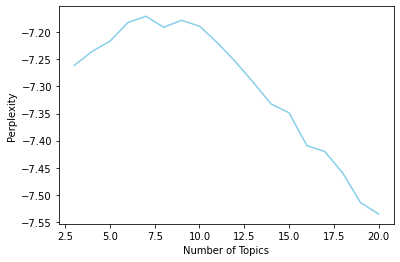

In [17]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

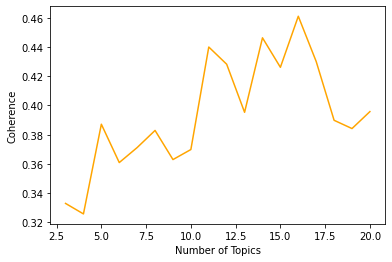

In [18]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Most salient topic per file using results of Model of choice

In [21]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts_content):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num) + 1, 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    df = import_files_to_df(dir_name)
    file_names = df['filenames']
    sent_topics_df = pd.concat([file_names,sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# choosing the model
df_topic_sents_keywords = format_topics_sentences(ldamodel=models[13], corpus=corpus, texts=lst_texts_content)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Filename', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.to_csv('dominant_topic.csv', index=False)

## Splitting papers in different directories of Model of choice

In [22]:
# # create a function that splits all the papers in different folders according to the topic it belongs to
# # choose just one model first
# df_document_topic = df_dominant_topic[['Filename','Dominant_Topic']]

# def split_corp_per_topic(abs_dirname):
#     for index, row in df_document_topic.iterrows():  
#         sel_topic = int(row['Dominant_Topic'])
#         file_name = row['Filename']       
#         folder_topic = abs_dirname + str(sel_topic)
        
#         if not os.path.exists(folder_topic):
#             os.makedirs(folder_topic)

#         from_folder = abs_dirname + file_name
#         to_folder = os.path.join(folder_topic, file_name)
#         shutil.move(from_folder,to_folder)

        
# split_corp_per_topic(dir_name)

# def get_list_of_files(dir_name):
#     # create a list of file and sub directories 
#     # names in the given directory 
#     list_of_file = os.listdir(dir_name)
#     all_files = []
#     # Iterate over all the entries
#     for entry in list_of_file:
#         # Create full path
#         full_path = os.path.join(dir_name, entry)
#         # If entry is a directory then get the list of files in this directory 
#         if os.path.isdir(full_path):
#             all_files = all_files + get_list_of_files(full_path)
#         else:
#             all_files.append(full_path)
#     return all_files